# Introduction

Soccer is an ever-evolving sport, from managers utilizing different formations and players learning new skills to beat defenders and goalkeepers. As defenses and teams learn to adjust to these new tactics, even newer strategies need to be discovered so the offense can continue to have an upper hand. Well, with this changing landscape, a manager may try to play his players differently. For example, what if a defender may be better as an attacker? How does the manager get an idea on what kinds of players may be utilized else where on the field? Or is a player not getting enough time when their on-field performance, though limited, shows potential for stardom? My clustering model will attempt to classify players from the 2025 MLS season into player roles based off their statistics. The numbers will be a combination of base stats and per90 numbers, which are used to provide some fairness for players who may be playing off the bench and do not get as many minutes as the normal starter. The initial dataset is taken from FBRef.com, which is a website that stores statistics from all phases of the game for any player who has made an appearance in the MLS this past regurlar season. There are stats based off shooting, passing, dribbles, defensive actions, and your normal, base stats. Through this process, I will attempt to find the most impactful stats, and based off of those, I will create clusters that make sense off their significant variables and we will see what results it gives based off the players assigned to each cluster. If all goes well, this should answer how players should be used and provide managers and coaching staffs more information to analyze their own teams and help scout their opponents.

## What is clustering? 

Clustering is an unsupervised machine learning technique that groups similar data points together based on their features and does not rely on pre-determined labels. It identifies underlying patterns in your data and forms clusters to group your data points together based off these patterns and traits. The goal is for points in each cluster to be more similar to each other than variables in other clusters. One of the most common clustering methods is by using a distance metric, like Euclidean distance, to group variables by similarity to each other, as they should be "close" to one another if they are inherently similar. 

K-Means is a popular clustering model and it works by first setting a number of clusters (K number of clusters) and placing these K clusters into random spots. Each data value is then assigned the nearest K, and these groupings are what form our clusters that we need to draw insights from our models. The center of the clusters (the centroid) are determined by the mean value of each data point within that cluster, so they are changing often until all the clusters are stable and all data has grouped in their appropiate clusters. K-Means is an efficient, simple model to use, though it relies heavily upon your K number of clusters, though there are methods used to find the optimal number of clusters, these methods are called the Elbow Method and Silhouette Analysis, and by using these methods you may find your best number of clusters to analyze. 

In [137]:
import pandas as pd
import requests
from bs4 import BeautifulSoup, Comment
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from io import StringIO
import time
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
#!pip install lxml
#!pip install bs4
#!pip install selenium
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [ ]:
# collect all the data urls

urls = {
    "standard": "https://fbref.com/en/comps/22/stats/Major-League-Soccer-Stats",
    "shooting": "https://fbref.com/en/comps/22/shooting/Major-League-Soccer-Stats",
    "passing": "https://fbref.com/en/comps/22/passing/Major-League-Soccer-Stats",
    "defense": "https://fbref.com/en/comps/22/defense/Major-League-Soccer-Stats",
    "possession": "https://fbref.com/en/comps/22/possession/Major-League-Soccer-Stats",
    "gca": "https://fbref.com/en/comps/22/gca/Major-League-Soccer-Stats"
}


In [ ]:
# using a combination of Selenium and BS, scrape each page for the player stats tables and then combine them into one master dataset

chrome_options = Options()
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-extensions")

driver = webdriver.Chrome(options=chrome_options)
driver.set_page_load_timeout(120)  
wait = WebDriverWait(driver, 30)
all_dfs = {}

for stat_type, url in urls.items():
    print(f"\nScraping {stat_type.upper()} page...")

    max_attempts = 5
    for attempt in range(max_attempts):
        try:
            driver.get(url)
            time.sleep(3)  
            break
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}. Retrying in 5s...")
            time.sleep(5)
    else:
        print(f"Failed to load {stat_type} page after multiple attempts")
        continue

    button_id = f"stats_{stat_type}_control"
    table_id = f"stats_{stat_type}"

    try:
        button = wait.until(EC.element_to_be_clickable((By.ID, button_id)))
        driver.execute_script("arguments[0].scrollIntoView(true);", button)
        time.sleep(1)
        driver.execute_script("arguments[0].click();", button)
    except Exception:
        print(f"Button {button_id} not clickable, continuing...")

    time.sleep(2)  

    html = driver.page_source
    soup = BeautifulSoup(html, "lxml")
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    table_html = [c for c in comments if table_id in c]

    if table_html:
        df = pd.read_html(str(table_html[0]))[0]
        print(f"Extracted {stat_type} table from commented HTML ({df.shape[0]} rows)")
    else:
        try:
            df = pd.read_html(html)[-1]
            print(f"Using visible table for {stat_type} ({df.shape[0]} rows)")
        except Exception:
            print(f"Could not find table for {stat_type}")
            continue

    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    if 'Player' in df.columns and 'Squad' in df.columns:
        df['Player'] = df['Player'].str.strip()
        df['Squad'] = df['Squad'].str.strip()
        df.drop_duplicates(subset=['Player', 'Squad'], inplace=True)
   
    all_dfs[stat_type] = df
   
    filename = f"mls_2025_players_{stat_type}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename} ({df.shape[0]} rows, {df.shape[1]} cols)")

    time.sleep(2)  

driver.quit()



Scraping STANDARD page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted standard table from commented HTML (917 rows)
Saved mls_2025_players_standard.csv (917 rows, 37 cols)

Scraping SHOOTING page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted shooting table from commented HTML (917 rows)
Saved mls_2025_players_shooting.csv (917 rows, 26 cols)

Scraping PASSING page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted passing table from commented HTML (917 rows)
Saved mls_2025_players_passing.csv (917 rows, 32 cols)

Scraping DEFENSE page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted defense table from commented HTML (917 rows)
Saved mls_2025_players_defense.csv (917 rows, 25 cols)

Scraping POSSESSION page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted possession table from commented HTML (917 rows)
Saved mls_2025_players_possession.csv (917 rows, 31 cols)

Scraping GCA page...


C:\Users\jonat\AppData\Local\Temp\ipykernel_30532\2715233330.py:53: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table_html[0]))[0]


Extracted gca table from commented HTML (917 rows)
Saved mls_2025_players_gca.csv (917 rows, 25 cols)


In [ ]:
# combine the tables 

master = all_dfs['standard'].copy()

master['Unnamed: 1_level_0_Player'] = master['Unnamed: 1_level_0_Player'].str.strip()
master['Unnamed: 4_level_0_Squad'] = master['Unnamed: 4_level_0_Squad'].str.strip()
master = master.drop_duplicates(subset=['Unnamed: 1_level_0_Player', 'Unnamed: 4_level_0_Squad'])

for name, df in all_dfs.items():
    if name == 'standard':
        continue

    print(f"\nProcessing {name} table (original rows: {df.shape[0]})")

    # Clean Player and Squad
    df['Unnamed: 1_level_0_Player'] = df['Unnamed: 1_level_0_Player'].str.strip()
    df['Unnamed: 4_level_0_Squad'] = df['Unnamed: 4_level_0_Squad'].str.strip()

    # Drop duplicates
    df = df.drop_duplicates(subset=['Unnamed: 1_level_0_Player', 'Unnamed: 4_level_0_Squad'])
    print(f"{name} table after dropping duplicates: {df.shape[0]} rows")

    # Merge safely on Player + Squad
    master = master.merge(df, on=['Unnamed: 1_level_0_Player', 'Unnamed: 4_level_0_Squad'], how='left', suffixes=('', f'_{name}'))
    print(f"Merged {name}, current shape: {master.shape}")

master = master.loc[:, ~master.columns.duplicated()]

master.to_csv("mls_player_master.csv", index=False)
print(f"\nMaster dataset saved with {master.shape[0]} players and {master.shape[1]} columns")


Processing shooting table (original rows: 917)
shooting table after dropping duplicates: 883 rows
Merged shooting, current shape: (883, 61)

Processing passing table (original rows: 917)
passing table after dropping duplicates: 883 rows
Merged passing, current shape: (883, 91)

Processing defense table (original rows: 917)
defense table after dropping duplicates: 883 rows
Merged defense, current shape: (883, 114)

Processing possession table (original rows: 917)
possession table after dropping duplicates: 883 rows
Merged possession, current shape: (883, 143)

Processing gca table (original rows: 917)
gca table after dropping duplicates: 883 rows
Merged gca, current shape: (883, 166)

Master dataset saved with 883 players and 166 columns


In [8]:
master.columns.tolist()

['Unnamed: 0_level_0_Rk',
 'Unnamed: 1_level_0_Player',
 'Unnamed: 2_level_0_Nation',
 'Unnamed: 3_level_0_Pos',
 'Unnamed: 4_level_0_Squad',
 'Unnamed: 5_level_0_Age',
 'Unnamed: 6_level_0_Born',
 'Playing Time_MP',
 'Playing Time_Starts',
 'Playing Time_Min',
 'Playing Time_90s',
 'Performance_Gls',
 'Performance_Ast',
 'Performance_G+A',
 'Performance_G-PK',
 'Performance_PK',
 'Performance_PKatt',
 'Performance_CrdY',
 'Performance_CrdR',
 'Expected_xG',
 'Expected_npxG',
 'Expected_xAG',
 'Expected_npxG+xAG',
 'Progression_PrgC',
 'Progression_PrgP',
 'Progression_PrgR',
 'Per 90 Minutes_Gls',
 'Per 90 Minutes_Ast',
 'Per 90 Minutes_G+A',
 'Per 90 Minutes_G-PK',
 'Per 90 Minutes_G+A-PK',
 'Per 90 Minutes_xG',
 'Per 90 Minutes_xAG',
 'Per 90 Minutes_xG+xAG',
 'Per 90 Minutes_npxG',
 'Per 90 Minutes_npxG+xAG',
 'Unnamed: 36_level_0_Matches',
 'Unnamed: 0_level_0_Rk_shooting',
 'Unnamed: 2_level_0_Nation_shooting',
 'Unnamed: 3_level_0_Pos_shooting',
 'Unnamed: 5_level_0_Age_shooting

In [9]:
master.head()

,Unnamed: 0_level_0_Rk,Unnamed: 1_level_0_Player,Unnamed: 2_level_0_Nation,Unnamed: 3_level_0_Pos,Unnamed: 4_level_0_Squad,Unnamed: 5_level_0_Age,Unnamed: 6_level_0_Born,Playing Time_MP,Playing Time_Starts,Playing Time_Min,...,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def,Unnamed: 24_level_0_Matches_gca
0,1,Paxten Aaronson,us USA,MF,Colorado Rapids,22-067,2003,7,6,572,...,0,1,0.16,1,0,0,0,0,0,Matches
1,2,Liel Abada,il ISR,"FW,MF",Charlotte,24-029,2001,32,17,1481,...,1,5,0.30,3,0,0,1,1,0,Matches
2,3,Wessam Abou Ali,ps PLE,FW,Columbus Crew,26-301,1999,5,4,303,...,0,2,0.60,1,0,0,0,1,0,Matches
3,4,Luis Abram,pe PER,DF,Atlanta Utd,29-247,1996,21,16,1493,...,0,0,0.00,0,0,0,0,0,0,Matches
4,5,Lalas Abubakar,gh GHA,DF,FC Dallas,30-311,1994,29,18,1656,...,1,1,0.05,1,0,0,0,0,0,Matches


In [21]:
# drop irrelevant columns
drop_cols = ['Unnamed: 0_level_0_Rk', 'Unnamed: 0_level_0_Rk', 'Unnamed: 5_level_0_Age','Unnamed: 6_level_0_Born','Playing Time_MP','Playing Time_Starts','Playing Time_Min',
             'Playing Time_90s','Unnamed: 36_level_0_Matches','Unnamed: 25_level_0_Matches','Unnamed: 0_level_0_Rk_shooting','Unnamed: 2_level_0_Nation_shooting','Unnamed: 3_level_0_Pos_shooting',
             'Unnamed: 5_level_0_Age_shooting','Unnamed: 6_level_0_Born_shooting', 'Unnamed: 0_level_0_Rk_passing','Unnamed: 2_level_0_Nation_passing','Unnamed: 3_level_0_Pos_passing','Unnamed: 5_level_0_Age_passing',
             'Unnamed: 6_level_0_Born_passing', 'Unnamed: 7_level_0_90s_passing','Unnamed: 31_level_0_Matches','Unnamed: 0_level_0_Rk_defense','Unnamed: 2_level_0_Nation_defense',
             'Unnamed: 3_level_0_Pos_defense','Unnamed: 5_level_0_Age_defense','Unnamed: 6_level_0_Born_defense','Unnamed: 7_level_0_90s_defense','Unnamed: 24_level_0_Matches',
             'Unnamed: 0_level_0_Rk_possession','Unnamed: 2_level_0_Nation_possession','Unnamed: 3_level_0_Pos_possession','Unnamed: 5_level_0_Age_possession','Unnamed: 6_level_0_Born_possession',
             'Unnamed: 7_level_0_90s_possession','Unnamed: 30_level_0_Matches','Unnamed: 0_level_0_Rk_gca','Unnamed: 2_level_0_Nation_gca','Unnamed: 3_level_0_Pos_gca','Unnamed: 5_level_0_Age_gca',
             'Unnamed: 6_level_0_Born_gca','Unnamed: 7_level_0_90s_gca', 'Unnamed: 24_level_0_Matches_gca', 'Unnamed: 7_level_0_90s',   ]

player_stats = master.drop(columns=drop_cols)

player_stats.head()

,Unnamed: 1_level_0_Player,Unnamed: 2_level_0_Nation,Unnamed: 3_level_0_Pos,Unnamed: 4_level_0_Squad,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
0,Paxten Aaronson,us USA,MF,Colorado Rapids,1,0,1,1,0,0,...,4,0,1,0.16,1,0,0,0,0,0
1,Liel Abada,il ISR,"FW,MF",Charlotte,5,1,6,5,0,0,...,2,1,5,0.30,3,0,0,1,1,0
2,Wessam Abou Ali,ps PLE,FW,Columbus Crew,3,0,3,3,0,0,...,1,0,2,0.60,1,0,0,0,1,0
3,Luis Abram,pe PER,DF,Atlanta Utd,0,0,0,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
4,Lalas Abubakar,gh GHA,DF,FC Dallas,1,0,1,1,0,0,...,0,1,1,0.05,1,0,0,0,0,0


In [14]:
player_stats.describe()

,Unnamed: 1_level_0_Player,Unnamed: 2_level_0_Nation,Unnamed: 3_level_0_Pos,Unnamed: 4_level_0_Squad,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
count,883,881,883,883,883,883,883,883,883,883,...,883,883,883,883,883,883,883,883,883,883
unique,851,87,11,31,23,17,30,22,8,10,...,18,6,26,103,20,8,6,7,9,4
top,Caden Clark,us USA,DF,Colorado Rapids,0,0,0,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
freq,2,320,248,34,467,464,338,469,824,817,...,492,628,315,315,361,794,780,718,765,853


In [ ]:
# get rid of the nation abbreviation

player_stats['Unnamed: 2_level_0_Nation'] = player_stats['Unnamed: 2_level_0_Nation'].str[2:]

player_stats

,Unnamed: 1_level_0_Player,Unnamed: 2_level_0_Nation,Unnamed: 3_level_0_Pos,Unnamed: 4_level_0_Squad,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
0,Paxten Aaronson,USA,MF,Colorado Rapids,1,0,1,1,0,0,...,4,0,1,0.16,1,0,0,0,0,0
1,Liel Abada,ISR,"FW,MF",Charlotte,5,1,6,5,0,0,...,2,1,5,0.30,3,0,0,1,1,0
2,Wessam Abou Ali,PLE,FW,Columbus Crew,3,0,3,3,0,0,...,1,0,2,0.60,1,0,0,0,1,0
3,Luis Abram,PER,DF,Atlanta Utd,0,0,0,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
4,Lalas Abubakar,GHA,DF,FC Dallas,1,0,1,1,0,0,...,0,1,1,0.05,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Walker Zimmerman,USA,DF,Nashville SC,0,2,2,0,0,0,...,1,0,2,0.12,1,0,0,1,0,0
879,Philip Zinckernagel,DEN,"FW,MF",Chicago Fire,15,12,27,15,0,0,...,6,3,21,0.75,8,6,3,2,0,2
880,Rida Zouhir,CAN,"MF,FW",D.C. United,0,0,0,0,0,0,...,0,0,2,0.54,2,0,0,0,0,0
881,Dario Župarić,BIH,DF,Portland Timbers,0,0,0,0,0,0,...,0,1,0,0.00,0,0,0,0,0,0


In [ ]:
# rename columns for simplicity

player_stats = player_stats.rename(columns={'Unnamed: 1_level_0_Player': 'Player', 'Unnamed: 2_level_0_Nation': 'Nation',
                                            'Unnamed: 4_level_0_Squad': 'Squad', 'Unnamed: 3_level_0_Pos': 'Position'})

player_stats

,Player,Nation,Position,Squad,Performance_Gls,Performance_Ast,Performance_G+A,Performance_G-PK,Performance_PK,Performance_PKatt,...,SCA Types_Fld,SCA Types_Def,GCA_GCA,GCA_GCA90,GCA Types_PassLive,GCA Types_PassDead,GCA Types_TO,GCA Types_Sh,GCA Types_Fld,GCA Types_Def
0,Paxten Aaronson,USA,MF,Colorado Rapids,1,0,1,1,0,0,...,4,0,1,0.16,1,0,0,0,0,0
1,Liel Abada,ISR,"FW,MF",Charlotte,5,1,6,5,0,0,...,2,1,5,0.30,3,0,0,1,1,0
2,Wessam Abou Ali,PLE,FW,Columbus Crew,3,0,3,3,0,0,...,1,0,2,0.60,1,0,0,0,1,0
3,Luis Abram,PER,DF,Atlanta Utd,0,0,0,0,0,0,...,0,0,0,0.00,0,0,0,0,0,0
4,Lalas Abubakar,GHA,DF,FC Dallas,1,0,1,1,0,0,...,0,1,1,0.05,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Walker Zimmerman,USA,DF,Nashville SC,0,2,2,0,0,0,...,1,0,2,0.12,1,0,0,1,0,0
879,Philip Zinckernagel,DEN,"FW,MF",Chicago Fire,15,12,27,15,0,0,...,6,3,21,0.75,8,6,3,2,0,2
880,Rida Zouhir,CAN,"MF,FW",D.C. United,0,0,0,0,0,0,...,0,0,2,0.54,2,0,0,0,0,0
881,Dario Župarić,BIH,DF,Portland Timbers,0,0,0,0,0,0,...,0,1,0,0.00,0,0,0,0,0,0


In [28]:
player_stats.columns.tolist()

['Player',
 'Nation',
 'Position',
 'Squad',
 'Performance_Gls',
 'Performance_Ast',
 'Performance_G+A',
 'Performance_G-PK',
 'Performance_PK',
 'Performance_PKatt',
 'Performance_CrdY',
 'Performance_CrdR',
 'Expected_xG',
 'Expected_npxG',
 'Expected_xAG',
 'Expected_npxG+xAG',
 'Progression_PrgC',
 'Progression_PrgP',
 'Progression_PrgR',
 'Per 90 Minutes_Gls',
 'Per 90 Minutes_Ast',
 'Per 90 Minutes_G+A',
 'Per 90 Minutes_G-PK',
 'Per 90 Minutes_G+A-PK',
 'Per 90 Minutes_xG',
 'Per 90 Minutes_xAG',
 'Per 90 Minutes_xG+xAG',
 'Per 90 Minutes_npxG',
 'Per 90 Minutes_npxG+xAG',
 'Standard_Gls',
 'Standard_Sh',
 'Standard_SoT',
 'Standard_SoT%',
 'Standard_Sh/90',
 'Standard_SoT/90',
 'Standard_G/Sh',
 'Standard_G/SoT',
 'Standard_Dist',
 'Standard_FK',
 'Standard_PK',
 'Standard_PKatt',
 'Expected_xG_shooting',
 'Expected_npxG_shooting',
 'Expected_npxG/Sh',
 'Expected_G-xG',
 'Expected_np:G-xG',
 'Total_Cmp',
 'Total_Att',
 'Total_Cmp%',
 'Total_TotDist',
 'Total_PrgDist',
 'Short_C

In [ ]:
# rename all columns for even more simplicity

rename_dict = {
    # Performance
    'Performance_Gls': 'goals',
    'Performance_Ast': 'assists',
    'Performance_G+A': 'goals_assists',
    'Performance_G-PK': 'non_pk_goals',
    'Performance_PK': 'pks_made',
    'Performance_PKatt': 'pks_att',
    'Performance_CrdY': 'yellow_cards',
    'Performance_CrdR': 'red_cards',

    # Expected
    'Expected_xG': 'xg',
    'Expected_npxG': 'npxg',
    'Expected_xAG': 'xag',
    'Expected_npxG+xAG': 'npxg_xag',

    # Progression
    'Progression_PrgC': 'prog_carries',
    'Progression_PrgP': 'prog_passes',
    'Progression_PrgR': 'prog_receives',

    # Per 90
    'Per 90 Minutes_Gls': 'goals_per90',
    'Per 90 Minutes_Ast': 'assists_per90',
    'Per 90 Minutes_G+A': 'goals_assists_per90',
    'Per 90 Minutes_G-PK': 'non_pk_goals_per90',
    'Per 90 Minutes_G+A-PK': 'non_pk_goals_assists_per90',
    'Per 90 Minutes_xG': 'xg_per90',
    'Per 90 Minutes_xAG': 'xag_per90',
    'Per 90 Minutes_xG+xAG': 'xg_xag_per90',
    'Per 90 Minutes_npxG': 'npxg_per90',
    'Per 90 Minutes_npxG+xAG': 'npxg_xag_per90',

    # Shooting (Standard)
    'Standard_Gls': 'gls',
    'Standard_Sh': 'shots',
    'Standard_SoT': 'shots_on_target',
    'Standard_SoT%': 'sot_pct',
    'Standard_Sh/90': 'shots_per90',
    'Standard_SoT/90': 'sot_per90',
    'Standard_G/Sh': 'goals_per_shot',
    'Standard_G/SoT': 'goals_per_sot',
    'Standard_Dist': 'avg_shot_dist',
    'Standard_FK': 'fk_shots',
    'Standard_PK': 'pk_goals',
    'Standard_PKatt': 'pk_att',

    # Expected (shooting)
    'Expected_xG_shooting': 'xg_shoot',
    'Expected_npxG_shooting': 'npxg_shoot',
    'Expected_npxG/Sh': 'npxg_per_shot',
    'Expected_G-xG': 'g_minus_xg',
    'Expected_np:G-xG': 'npg_minus_xg',

    # Passing totals
    'Total_Cmp': 'passes_cmp',
    'Total_Att': 'passes_att',
    'Total_Cmp%': 'passes_cmp_pct',
    'Total_TotDist': 'pass_tot_dist',
    'Total_PrgDist': 'pass_prog_dist',

    # Short/Med/Long passing
    'Short_Cmp': 'short_cmp',
    'Short_Att': 'short_att',
    'Short_Cmp%': 'short_cmp_pct',
    'Medium_Cmp': 'med_cmp',
    'Medium_Att': 'med_att',
    'Medium_Cmp%': 'med_cmp_pct',
    'Long_Cmp': 'long_cmp',
    'Long_Att': 'long_att',
    'Long_Cmp%': 'long_cmp_pct',

    # Misc passing
    'Unnamed: 22_level_0_Ast': 'pass_ast',
    'Unnamed: 23_level_0_xAG': 'pass_xag',
    'Expected_xA': 'xA',
    'Expected_A-xAG': 'a_minus_xag',
    'Unnamed: 26_level_0_KP': 'key_passes',
    'Unnamed: 27_level_0_1/3': 'passes_final_third',
    'Unnamed: 28_level_0_PPA': 'ppa',
    'Unnamed: 29_level_0_CrsPA': 'crosses_pen_area',
    'Unnamed: 30_level_0_PrgP': 'prog_passes_2',

    # Defending - Tackles/Challenges
    'Tackles_Tkl': 'tackles',
    'Tackles_TklW': 'tackles_won',
    'Tackles_Def 3rd': 'tkl_def3',
    'Tackles_Mid 3rd': 'tkl_mid3',
    'Tackles_Att 3rd': 'tkl_att3',
    'Challenges_Tkl': 'challenges_tkl',
    'Challenges_Att': 'challenges_att',
    'Challenges_Tkl%': 'challenges_tkl_pct',
    'Challenges_Lost': 'challenges_lost',

    # Blocks
    'Blocks_Blocks': 'blocks',
    'Blocks_Sh': 'blocks_shots',
    'Blocks_Pass': 'blocks_passes',
    'Unnamed: 20_level_0_Int': 'interceptions',
    'Unnamed: 21_level_0_Tkl+Int': 'tkl_plus_int',
    'Unnamed: 22_level_0_Clr': 'clearances',
    'Unnamed: 23_level_0_Err': 'errors',

    # Possession - Touches, Carries, Take-Ons, Receiving
    'Touches_Touches': 'touches',
    'Touches_Def Pen': 'touches_def_pen',
    'Touches_Def 3rd': 'touches_def3',
    'Touches_Mid 3rd': 'touches_mid3',
    'Touches_Att 3rd': 'touches_att3',
    'Touches_Att Pen': 'touches_att_pen',
    'Touches_Live': 'touches_live',

    'Take-Ons_Att': 'takeons_att',
    'Take-Ons_Succ': 'takeons_succ',
    'Take-Ons_Succ%': 'takeons_succ_pct',
    'Take-Ons_Tkld': 'takeons_tkld',
    'Take-Ons_Tkld%': 'takeons_tkld_pct',

    'Carries_Carries': 'carries',
    'Carries_TotDist': 'carry_tot_dist',
    'Carries_PrgDist': 'carry_prog_dist',
    'Carries_PrgC': 'carry_prog_carries',
    'Carries_1/3': 'carry_final_third',
    'Carries_CPA': 'carry_pen_area',
    'Carries_Mis': 'carry_miscontrols',
    'Carries_Dis': 'carry_dispossessed',

    'Receiving_Rec': 'receiving',
    'Receiving_PrgR': 'prog_receives_2',

    # SCA / GCA (Shot and Goal Creating Actions)
    'SCA_SCA': 'sca',
    'SCA_SCA90': 'sca_per90',
    'SCA Types_PassLive': 'sca_pass_live',
    'SCA Types_PassDead': 'sca_pass_dead',
    'SCA Types_TO': 'sca_takeon',
    'SCA Types_Sh': 'sca_shot',
    'SCA Types_Fld': 'sca_fouled',
    'SCA Types_Def': 'sca_defense',

    'GCA_GCA': 'gca',
    'GCA_GCA90': 'gca_per90',
    'GCA Types_PassLive': 'gca_pass_live',
    'GCA Types_PassDead': 'gca_pass_dead',
    'GCA Types_TO': 'gca_takeon',
    'GCA Types_Sh': 'gca_shot',
    'GCA Types_Fld': 'gca_fouled',
    'GCA Types_Def': 'gca_defense'
}

player_stats = player_stats.rename(columns=rename_dict)

In [31]:
player_stats.columns.tolist()

['Player',
 'Nation',
 'Position',
 'Squad',
 'goals',
 'assists',
 'goals_assists',
 'non_pk_goals',
 'pks_made',
 'pks_att',
 'yellow_cards',
 'red_cards',
 'xg',
 'npxg',
 'xag',
 'npxg_xag',
 'prog_carries',
 'prog_passes',
 'prog_receives',
 'goals_per90',
 'assists_per90',
 'goals_assists_per90',
 'non_pk_goals_per90',
 'non_pk_goals_assists_per90',
 'xg_per90',
 'xag_per90',
 'xg_xag_per90',
 'npxg_per90',
 'npxg_xag_per90',
 'gls',
 'shots',
 'shots_on_target',
 'sot_pct',
 'shots_per90',
 'sot_per90',
 'goals_per_shot',
 'goals_per_sot',
 'avg_shot_dist',
 'fk_shots',
 'pk_goals',
 'pk_att',
 'xg_shoot',
 'npxg_shoot',
 'npxg_per_shot',
 'g_minus_xg',
 'npg_minus_xg',
 'passes_cmp',
 'passes_att',
 'passes_cmp_pct',
 'pass_tot_dist',
 'pass_prog_dist',
 'short_cmp',
 'short_att',
 'short_cmp_pct',
 'med_cmp',
 'med_att',
 'med_cmp_pct',
 'long_cmp',
 'long_att',
 'long_cmp_pct',
 'pass_ast',
 'pass_xag',
 'xA',
 'a_minus_xag',
 'key_passes',
 'passes_final_third',
 'ppa',
 'cr

In [ ]:
# find the nulls
player_stats.isnull().sum()[player_stats.isnull().sum() > 0]

Nation                  2
sot_pct               165
goals_per_shot        165
goals_per_sot         275
avg_shot_dist         165
npxg_per_shot         165
passes_cmp_pct          7
short_cmp_pct          13
med_cmp_pct            19
long_cmp_pct           58
challenges_tkl_pct    110
takeons_succ_pct      137
takeons_tkld_pct      137
dtype: int64

In [46]:
player_stats.shape

(883, 123)

In [47]:
# Fill with 0 for performance ratios where NaN means "no attempts"
cols_fill_zero = [
    'sot_pct', 'goals_per_shot', 'goals_per_sot', 'avg_shot_dist', 'npxg_per_shot',
    'passes_cmp_pct', 'short_cmp_pct', 'med_cmp_pct', 'long_cmp_pct',
    'challenges_tkl_pct', 'takeons_succ_pct', 'takeons_tkld_pct'
]

player_stats[cols_fill_zero] = player_stats[cols_fill_zero].fillna(0)

In [49]:
player_stats.isnull().sum()

Player           0
Nation           2
Position         0
Squad            0
goals            0
                ..
gca_pass_dead    0
gca_takeon       0
gca_shot         0
gca_fouled       0
gca_defense      0
Length: 123, dtype: int64

In [ ]:
# drop the 2 because we have enough variables we can just get rid of these rows

player_stats = player_stats.drop(columns=['Nation'], errors='ignore')

In [52]:
player_stats.isnull().sum().sum()

np.int64(0)

# Feature Selection

In [54]:
player_stats.columns.tolist()

['Player',
 'Position',
 'Squad',
 'goals',
 'assists',
 'goals_assists',
 'non_pk_goals',
 'pks_made',
 'pks_att',
 'yellow_cards',
 'red_cards',
 'xg',
 'npxg',
 'xag',
 'npxg_xag',
 'prog_carries',
 'prog_passes',
 'prog_receives',
 'goals_per90',
 'assists_per90',
 'goals_assists_per90',
 'non_pk_goals_per90',
 'non_pk_goals_assists_per90',
 'xg_per90',
 'xag_per90',
 'xg_xag_per90',
 'npxg_per90',
 'npxg_xag_per90',
 'gls',
 'shots',
 'shots_on_target',
 'sot_pct',
 'shots_per90',
 'sot_per90',
 'goals_per_shot',
 'goals_per_sot',
 'avg_shot_dist',
 'fk_shots',
 'pk_goals',
 'pk_att',
 'xg_shoot',
 'npxg_shoot',
 'npxg_per_shot',
 'g_minus_xg',
 'npg_minus_xg',
 'passes_cmp',
 'passes_att',
 'passes_cmp_pct',
 'pass_tot_dist',
 'pass_prog_dist',
 'short_cmp',
 'short_att',
 'short_cmp_pct',
 'med_cmp',
 'med_att',
 'med_cmp_pct',
 'long_cmp',
 'long_att',
 'long_cmp_pct',
 'pass_ast',
 'pass_xag',
 'xA',
 'a_minus_xag',
 'key_passes',
 'passes_final_third',
 'ppa',
 'crosses_pen_a

In [ ]:
# keep these separate so we can use them for identification later

id_cols = ['Player', 'Squad', 'Position']

numeric_cols = player_stats.drop(columns=id_cols) 
# X = player_stats.drop(columns= id_cols)

In [ ]:
# convert all the rows into numeric values instead of object values

numeric_player_stats = numeric_cols.apply(pd.to_numeric, errors='coerce')

In [76]:
numeric_player_stats.dtypes.tolist()

[dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('floa

In [ ]:
# create a correlation matrix to see how the variables are related to each other

corr = numeric_player_stats.corr().abs()

In [78]:
print(corr)

                  goals   assists  goals_assists  non_pk_goals  pks_made  \
goals          1.000000  0.580838       0.939062      0.987911  0.714178   
assists        0.580838  1.000000       0.825260      0.592822  0.329007   
goals_assists  0.939062  0.825260       1.000000      0.935736  0.634419   
non_pk_goals   0.987911  0.592822       0.935736      1.000000  0.597034   
pks_made       0.714178  0.329007       0.634419      0.597034  1.000000   
...                 ...       ...            ...           ...       ...   
gca_pass_dead  0.256096  0.526055       0.399820      0.255513  0.171549   
gca_takeon     0.603080  0.504947       0.631638      0.609897  0.367008   
gca_shot       0.454955  0.401128       0.485030      0.462532  0.265877   
gca_fouled     0.463134  0.308139       0.451437      0.421222  0.494721   
gca_defense    0.122396  0.258540       0.194094      0.139146  0.005101   

                pks_att  yellow_cards  red_cards        xg      npxg  ...  \
goals     

In [ ]:
# we have a large dataset, so lets just look at the most correlated variables

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

In [ ]:
# suggest columns that are above 0.9 to be dropped, as they are highly correlated with other features

col_to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print("Highly correlated columns to review for possible drop:", col_to_drop)

Highly correlated columns to review for possible drop: ['goals_assists', 'non_pk_goals', 'pks_att', 'xg', 'npxg', 'npxg_xag', 'non_pk_goals_per90', 'non_pk_goals_assists_per90', 'xg_xag_per90', 'npxg_per90', 'npxg_xag_per90', 'gls', 'shots', 'shots_on_target', 'shots_per90', 'pk_goals', 'pk_att', 'xg_shoot', 'npxg_shoot', 'npg_minus_xg', 'passes_att', 'pass_tot_dist', 'pass_prog_dist', 'short_cmp', 'short_att', 'med_cmp', 'med_att', 'long_cmp', 'long_att', 'pass_ast', 'pass_xag', 'xA', 'key_passes', 'passes_final_third', 'ppa', 'prog_passes_2', 'tackles_won', 'tkl_def3', 'tkl_mid3', 'challenges_tkl', 'challenges_att', 'challenges_lost', 'tkl_plus_int', 'touches', 'touches_def3', 'touches_mid3', 'touches_att3', 'touches_att_pen', 'touches_live', 'takeons_succ', 'takeons_tkld', 'carries', 'carry_tot_dist', 'carry_prog_dist', 'carry_prog_carries', 'carry_final_third', 'receiving', 'prog_receives_2', 'sca', 'sca_pass_live', 'gca_pass_live']


# Sort all these columsn into their types for easier analysis

Shooting metrics:
gls, non_pk_goals, pk_goals, pk_att, xg, npxg, npxg_xag, xg_shoot, npxg_shoot, npg_minus_xg

Keep: 
npxg - shot quality (expected non-pen goals)
goals_per90 - measures ability to finish shots; regardless of playing time

Passing metrics:
passes_att, pass_tot_dist, pass_prog_dist, short_cmp, short_att, med_cmp, med_att, long_cmp, long_att, pass_ast, pass_xag, xA, key_passes, passes_final_third, ppa, prog_passes_2

Keep:
pass_prog_dist - measures progressive passes distance covered
xA - ability to create chances (expected assists)
passes_comp_pct - pass completion percentage


Defensive Metrics:
tackles_won, tkl_def3, tkl_mid3, challenges_tkl, challenges_att, challenges_lost, tkl_plus_int

Keep:
tkl_plus_int - measure of defensive actions (tackles and interceptions)
challenges_tkl_pct - tackle efficiency

Possession Metrics:
touches, touches_def3, touches_mid3, touches_att3, carries, carry_tot_dist, carry_prog_dist, carry_prog_carries, receiving, prog_receives_2

Keep:
carry_prog_dist - progressive carrying distance; how well does the player carry the ball into attacking positions
touches - what is the volume that the player is actually on the ball

Creative Metrics:
sca, sca_pass_live, gca_pass_live

Keep:
sca - just keep how many shot creating actions a player has

In [ ]:
# collect the columns we are keeping
cols_to_keep = ['goals_per90', 'assists_per90', 'npxg_per90', 'xA', 'passes_cmp_pct', 'pass_prog_dist',
                'tkl_plus_int', 'challenges_tkl_pct', 'carry_prog_dist', 'touches', 'sca_per90']

In [82]:
filtered_player_stats = numeric_player_stats[cols_to_keep]

In [84]:
filtered_player_stats.columns

Index(['goals_per90', 'assists_per90', 'npxg_per90', 'xA', 'passes_cmp_pct',
       'pass_prog_dist', 'tkl_plus_int', 'challenges_tkl_pct',
       'carry_prog_dist', 'touches', 'sca_per90'],
      dtype='object')

# Feature Scaling and Clustering Model

In [ ]:
# create our X variable and our identification columns

X = filtered_player_stats.copy()

player_info = player_stats[id_cols].copy()

k=2, Silhouette Score=0.3032
k=3, Silhouette Score=0.3078
k=4, Silhouette Score=0.2687
k=5, Silhouette Score=0.2371
k=6, Silhouette Score=0.2507
k=7, Silhouette Score=0.2481
k=8, Silhouette Score=0.2112
k=9, Silhouette Score=0.1952
k=10, Silhouette Score=0.2139


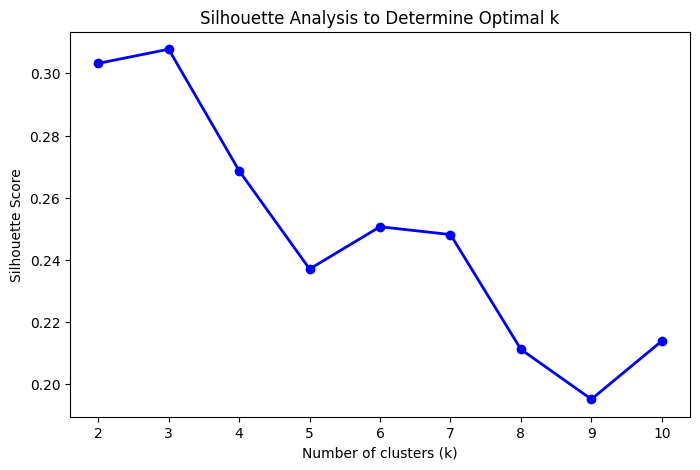

Optimal number of clusters: 3
            Player            Squad Position  Cluster
0  Paxten Aaronson  Colorado Rapids       MF        0
1       Liel Abada        Charlotte    FW,MF        0
2  Wessam Abou Ali    Columbus Crew       FW        0
3       Luis Abram      Atlanta Utd       DF        1
4   Lalas Abubakar        FC Dallas       DF        1


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# fill any remaining missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# scale the data so it can be compared properly
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# this next section was first used to find the optimal number of clusters using the silhouette score method, but 
# after running it and trying it out with the suggested number of clusters, I determined that more were needed
# the suggestion of 3 was just not enough to accurately describe the different positions and roles in soccer, so we went with more clusters

# k_values = range(2,11)
# silhouette_scores = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     cluster_labels = kmeans.fit_predict(X_scaled)
#     score = silhouette_score(X_scaled, cluster_labels)
#     silhouette_scores.append(score)
#     print(f"k={k}, Silhouette Score={score:.4f}")

# plt.figure(figsize=(8, 5))
# plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2)
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Silhouette Score")
# plt.title("Silhouette Analysis to Determine Optimal k")
# plt.show()


# k_optimal = k_values[silhouette_scores.index(max(silhouette_scores))]
# print(f"Optimal number of clusters: {k_optimal}")

# kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
# player_info['Cluster'] = kmeans_final.fit_predict(X_scaled)

# -------------------------
# 5️⃣ Optional: inspect cluster assignment
# -------------------------
print(player_info.head())

In [ ]:
# join the clustered data back with the player info for easier analysis later

clustered_data = player_info.join(
    pd.DataFrame(X_scaled, columns=filtered_player_stats.columns)
)

In [ ]:
# here is the actual modeling with more clusters, which I determined worked better for true soccer analysis

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X_scaled)

player_info['Cluster'] = kmeans.labels_

clustered_data = pd.concat([player_info, pd.DataFrame(X_scaled, columns=X.columns)], axis=1)
cluster_summary = clustered_data.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

         goals_per90  assists_per90  npxg_per90        xA  passes_cmp_pct  \
Cluster                                                                     
0           5.609547       3.455000    0.567305 -0.585090       -0.229289   
1           0.427665       0.461151    0.069269  2.561118       -0.187259   
2          -0.378900      -0.363746   28.814538 -0.694678       -6.064768   
3          -0.253549      -0.159809   -0.128595  0.060794        0.431694   
4          -0.109608      -0.176618    0.000147 -0.579993       -0.248087   
5           0.008725       0.024044   -0.016242 -0.237717        0.090330   
6          -0.378900      -0.363746   -0.153593 -0.694678       -5.188786   

         pass_prog_dist  tkl_plus_int  challenges_tkl_pct  carry_prog_dist  \
Cluster                                                                      
0             -0.853927     -0.959458           -1.575233        -0.989834   
1              0.411746      0.607289           -0.096794         1.4786

How do we understand this? Well 0 is a mean value for each column on each cluster. So if your score is 0, that means you are average at that part of the game. A positive score means you're better at that category or you are more likely to do it (for example, more likely to score or assist goals). A negative score suggests you are not very good at that part of the game, or maybe you do it often and your numbers are higher than others, but your rate of success may be down. 

We also see an outlier here in cluster 2, as most numbers are negative except for the non-penalty expected goals per 90 minutes. No player should ever be at 28 expected goals while under-performing everywhere else, and upon examination of that cluster, I found that one player was present, and they are purely a bench player who saw action in only a few games. This cluster will therefore be labeled as an outlier and not impactful. 

# Interpret and Label Clusters

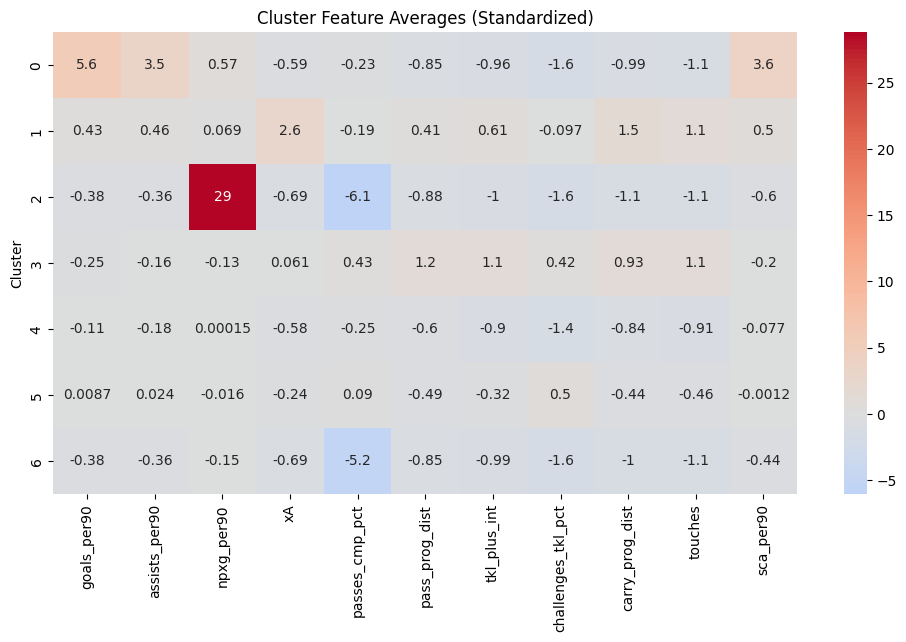

In [ ]:
# create a heatmap to visualize the cluster centers

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary, annot=True, cmap="coolwarm", center=0)
plt.title("Cluster Feature Averages (Standardized)")
plt.show()

In [ ]:
# based on the above scores, label each cluster and then join the cluster to each player's information

cluster_names = {
    0: 'Elite Finishers/Strikers',
    1: 'Creative Playmakers',
    2: 'Outlier',
    3: 'Box-to-Box Midfielders',
    4: 'Pure Defenders',
    5: 'Holding Midfielders (Support)',
    6: 'Deep Defenders (Sweepers)'
}

player_info['Role'] = player_info['Cluster'].map(cluster_names)
player_info

,Player,Squad,Position,Cluster,Role
0,Paxten Aaronson,Colorado Rapids,MF,4,Pure Defenders
1,Liel Abada,Charlotte,"FW,MF",5,Holding Midfielders (Support)
2,Wessam Abou Ali,Columbus Crew,FW,4,Pure Defenders
3,Luis Abram,Atlanta Utd,DF,3,Box-to-Box Midfielders
4,Lalas Abubakar,FC Dallas,DF,3,Box-to-Box Midfielders
...,...,...,...,...,...
878,Walker Zimmerman,Nashville SC,DF,3,Box-to-Box Midfielders
879,Philip Zinckernagel,Chicago Fire,"FW,MF",1,Creative Playmakers
880,Rida Zouhir,D.C. United,"MF,FW",5,Holding Midfielders (Support)
881,Dario Župarić,Portland Timbers,DF,3,Box-to-Box Midfielders


What do we learn from this? Well, I am not sure it worked, as a player like Paxten Aaronson is far closer to a pure forward than a pure defender. And Walker Zimmerman is a pure defender at Center-Back, and does not usually progress the ball at the level of a box-to-box midfielder. Now, a deeper dive into the players clustered may prove beneficial and could show further if the model was accurate with only a few misses, or if it missed the bigger picture. However, time does not allow for that right now, so it will have to be done in future research/analysis. 

One suggestion would be to look at the chosen stats used to cluster these players, as they may be skewed for diffent players and an overlap of numbers may be causing players, such as Aaronson, to be completely wrong. 

What I learned from this is that numbers don't always tell the story. If these clusters are accurate, and Walker Zimmerman's numbers suggest he is best as a box-to-box midfielder, than the eye test conflicts with that, and the eye test is sometimes the most important aspect of where to place players. Maybe if he were to transition to a more midfielder role he would excel, but we have no way of knowing that right now. So once again, more time and analysis will need to be given to this project to learn more. 

What impact does this have currently? I would say this has a negative impact right now, as it would suggest playing many players out of position, which if used in actual matches, may result in disfunction for a team and they could lose valuable points due to an experiment, of sorts. Therefore, with the current player role suggestions, on the surface, it seems to be potentially detrimental to team success. 

# References
https://fbref.com/en/comps/22/stats/Major-League-Soccer-Stats - this is the starting page for the stats I gathered and used through my project

I also utilized OpenAI's ChatGPT to assist in web-scraping and accelerating other areas of the project (the renaming dictionary, for example)
